In [ ]:
!pip install transformers[sentencepiece]
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


2025-04-30 20:58:07.668861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 20:58:07.668900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 20:58:07.670055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 20:58:07.676116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 20:58:08.258871: W tensorflow/compiler/tf2

Epoch 1/30 — Avg Loss: 0.451813
Epoch 2/30 — Avg Loss: 0.404360
Epoch 3/30 — Avg Loss: 0.404226
Epoch 4/30 — Avg Loss: 0.398687
Epoch 5/30 — Avg Loss: 0.328397
Epoch 6/30 — Avg Loss: 0.224224
Epoch 7/30 — Avg Loss: 0.155695
Epoch 8/30 — Avg Loss: 0.117545
Epoch 9/30 — Avg Loss: 0.095166
Epoch 10/30 — Avg Loss: 0.081780
Epoch 11/30 — Avg Loss: 0.072630
Epoch 12/30 — Avg Loss: 0.066028
Epoch 13/30 — Avg Loss: 0.061334
Epoch 14/30 — Avg Loss: 0.057567
Epoch 15/30 — Avg Loss: 0.054428
Epoch 16/30 — Avg Loss: 0.052428
Epoch 17/30 — Avg Loss: 0.050274
Epoch 18/30 — Avg Loss: 0.048675
Epoch 19/30 — Avg Loss: 0.047518
Epoch 20/30 — Avg Loss: 0.045840
Epoch 21/30 — Avg Loss: 0.044111
Epoch 22/30 — Avg Loss: 0.042456
Epoch 23/30 — Avg Loss: 0.040718
Epoch 24/30 — Avg Loss: 0.039408
Epoch 25/30 — Avg Loss: 0.038221
Epoch 26/30 — Avg Loss: 0.037412
Epoch 27/30 — Avg Loss: 0.036835
Epoch 28/30 — Avg Loss: 0.036326
Epoch 29/30 — Avg Loss: 0.035643
Epoch 30/30 — Avg Loss: 0.035142


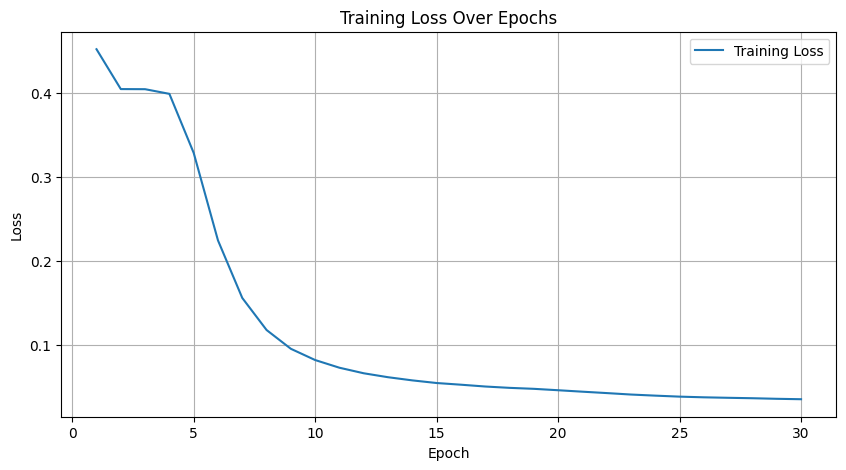

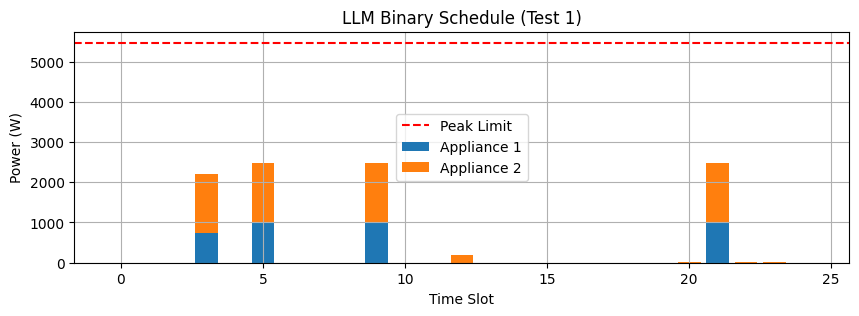

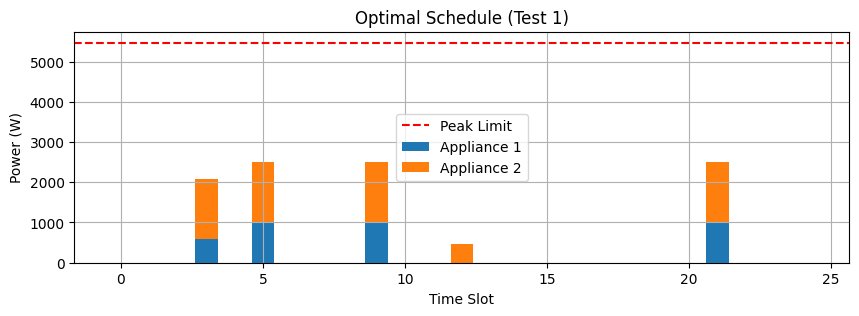

Test 1: Pred Cost=$0.63, Opt Cost=$0.64, Gap=$-0.01



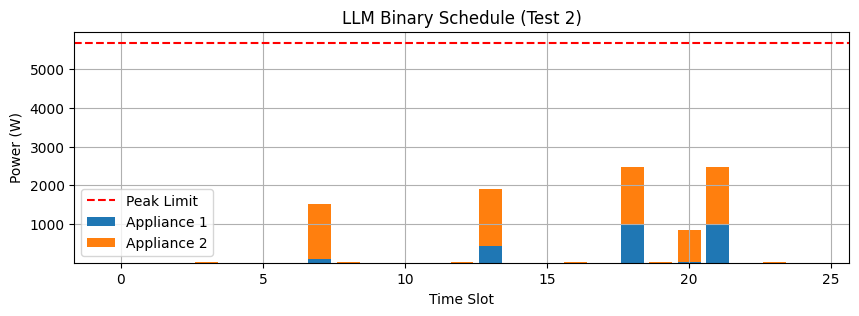

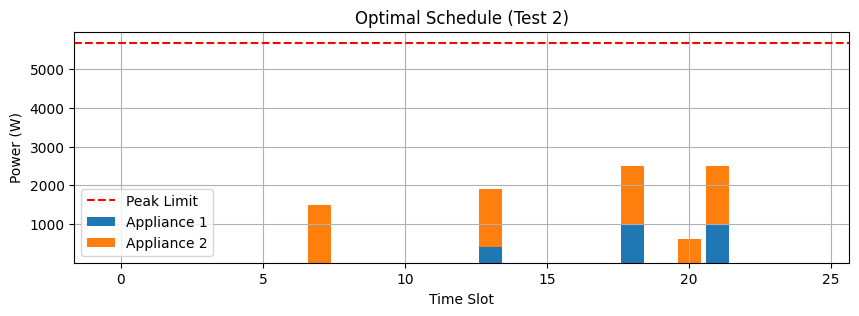

Test 2: Pred Cost=$0.56, Opt Cost=$0.53, Gap=$0.03



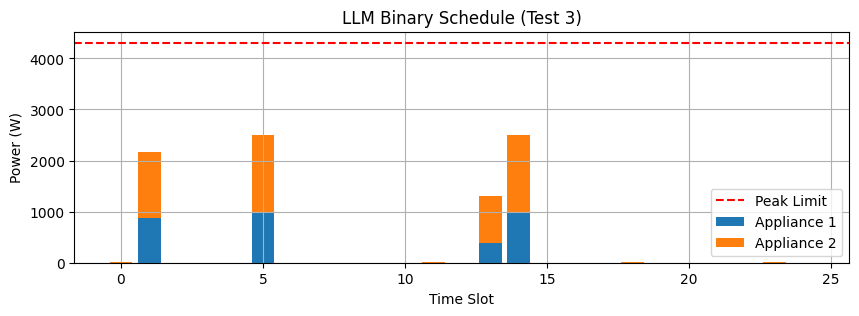

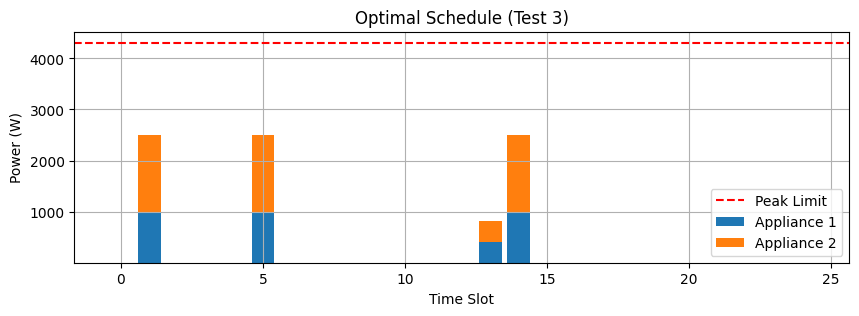

Test 3: Pred Cost=$0.61, Opt Cost=$0.59, Gap=$0.02



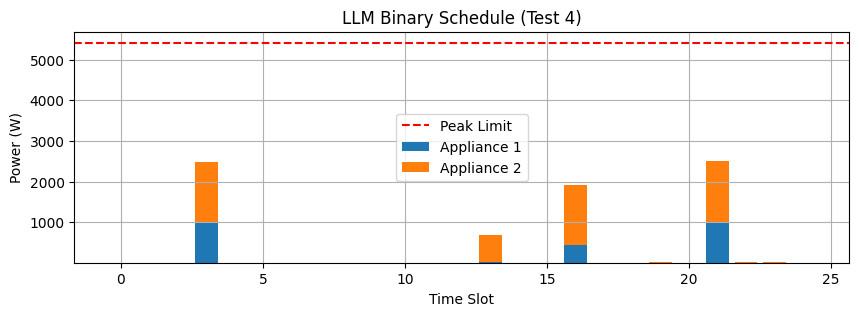

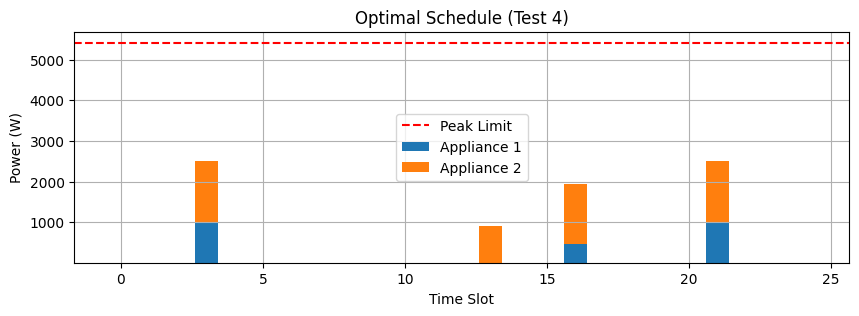

Test 4: Pred Cost=$0.49, Opt Cost=$0.50, Gap=$-0.01



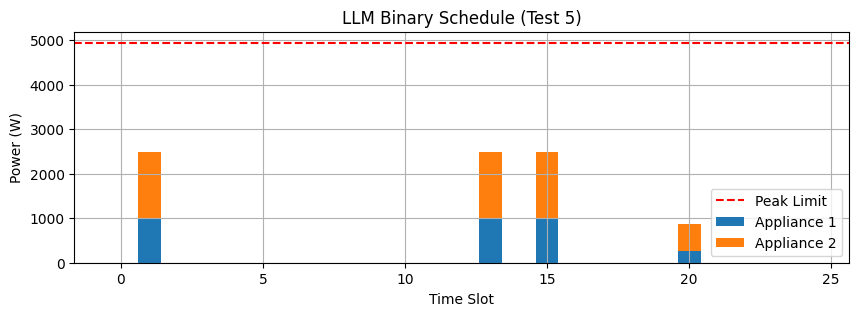

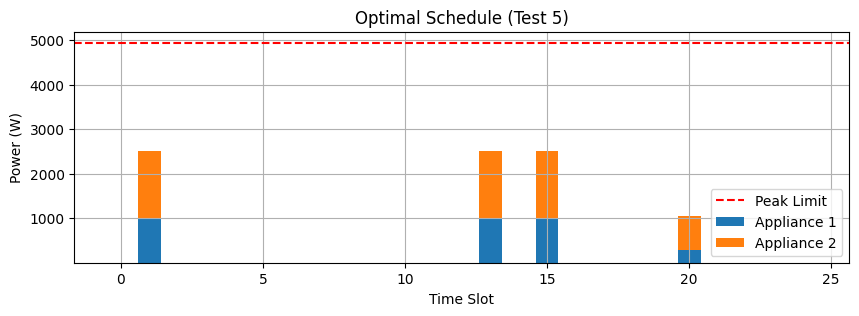

Test 5: Pred Cost=$0.57, Opt Cost=$0.58, Gap=$-0.01



In [ ]:
import cvxpy as cp
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import ElectraTokenizer, ElectraModel
torch.cuda.empty_cache()

# 1) Convex oracle: solve the LP with default solver (unchanged)
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False)
    # Round to 0/1
    return X.value.astype(float)

# 2) Structured Prompt Dataset (modified to include random energy requirements)
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        self.P_h = np.array([1000, 1500])
        # Define ranges for energy requirements (in Wh) for each appliance
        self.E_h_ranges = np.array([[2000, 4000], [4000, 8000]])  # Appliance 1: 2-4 kWh, Appliance 2: 4-8 kWh
        # Define the range for the peak limit (in Watts)
        self.peak_range = (2000, 6000)

        for _ in range(n_samples):
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
            # Sample energy requirements randomly from the given ranges for each appliance
            E_h = np.array([np.random.randint(low, high) for (low, high) in self.E_h_ranges])
            # Sample a peak limit randomly from the given range for each sample
            peak_limit = np.random.randint(*self.peak_range)
            X_opt = generate_optimal_schedule(price, self.P_h, E_h, peak_limit)
            self.prompts.append(self._build_prompt(price, E_h, peak_limit))
            self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))

    def _build_prompt(self, price, E_h, peak_limit):
        s = "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh" for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, E_h), start=1):
            s += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += f"\n[Output]\nProvide a {self.N}x{self.H} schedule matrix."
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 3) Model: ELECTRA → logits (unchanged)
class SupervisedTSLModel(nn.Module):
    def __init__(self, N, H):
        super().__init__()
        self.tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")
        self.electra = ElectraModel.from_pretrained("google/electra-base-discriminator")
        hidden = self.electra.config.hidden_size
        self.regressor = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, N * H)
        )

    def forward(self, prompts):
        enc = self.tokenizer(prompts,
                             padding=True,
                             truncation=True,
                             return_tensors="pt")
        device = next(self.electra.parameters()).device
        enc = {k: v.to(device) for k, v in enc.items()}
        out = self.electra(**enc).last_hidden_state[:, 0, :]  # CLS token representation
        return self.regressor(out)

# 4) Training with BCEWithLogitsLoss to get binary schedules (modified to track and plot loss)
def train_model(model, dataset, epochs=20, batch_size=16, lr=2e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optim = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    # Track losses for plotting
    train_losses = []

    for ep in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for prompts, targets in loader:
            logits = model(prompts).to(device)
            loss = loss_fn(logits, targets.to(device))
            optim.zero_grad()
            loss.backward()
            optim.step()
            running_loss += loss.item() * targets.size(0)

        epoch_loss = running_loss / len(dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {ep}/{epochs} — Avg Loss: {epoch_loss:.6f}")

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# 5) Test & plot just stacked bars (binary schedules) - modified to use random energy requirements
def test_and_plot(model, tests=3, N=25):
    P_h = np.array([1000, 1500])
    # Define ranges for energy requirements (same as in training)
    E_h_ranges = np.array([[2000, 4000], [4000, 8000]])
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")
    model.eval().to(device)

    for t_i in range(1, tests + 1):
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        # Sample energy requirements randomly for testing
        E_h = np.array([np.random.randint(low, high) for (low, high) in E_h_ranges])
        # Sample a peak limit randomly for testing
        peak = np.random.randint(2000, 6000)

        # Build the prompt using the randomized parameters
        p = "[Prices]\n" + "\n".join(f"Slot {i+1}: {v:.3f} $/kWh" for i, v in enumerate(price))
        p += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(P_h, E_h), start=1):
            p += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        p += f"\n[Peak Limit]\n{peak/1000:.1f} kW\n"
        p += "\n[Objective]\nMinimize total electricity cost.\n"
        p += f"\n[Output]\nProvide a {N}x2 schedule matrix."

        # Predict using the model
        with torch.no_grad():
            enc = tokenizer([p], padding=True, truncation=True,
                            return_tensors="pt").to(device)
            out = model.electra(**enc).last_hidden_state[:, 0, :]
            logits = model.regressor(out)
            probs = torch.sigmoid(logits).cpu().numpy()[0].reshape(N, 2)
        bin_sched = probs.astype(float)

        # Get the optimal schedule for comparison
        opt_sched = generate_optimal_schedule(price, P_h, E_h, peak)

        # Plot predicted binary schedule
        t = np.arange(N)
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.bar(t, bin_sched[:, 0]*P_h[0], label="Appliance 1")
        ax.bar(t, bin_sched[:, 1]*P_h[1],
               bottom=bin_sched[:, 0]*P_h[0], label="Appliance 2")
        ax.axhline(peak, color='r', ls='--', label="Peak Limit")
        ax.set_title(f"LLM Binary Schedule (Test {t_i})")
        ax.set_xlabel("Time Slot")
        ax.set_ylabel("Power (W)")
        ax.legend(), ax.grid(True)
        plt.show()

        # Plot optimal schedule
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.bar(t, opt_sched[:, 0]*P_h[0], label="Appliance 1")
        ax.bar(t, opt_sched[:, 1]*P_h[1],
               bottom=opt_sched[:, 0]*P_h[0], label="Appliance 2")
        ax.axhline(peak, color='r', ls='--', label="Peak Limit")
        ax.set_title(f"Optimal Schedule (Test {t_i})")
        ax.set_xlabel("Time Slot")
        ax.set_ylabel("Power (W)")
        ax.legend(), ax.grid(True)
        plt.show()

        # Print cost summary
        cost_pred = (price[:, None] * (bin_sched * P_h)/1000.0).sum()
        cost_opt  = (price[:, None] * (opt_sched * P_h)/1000.0).sum()
        print(f"Test {t_i}: Pred Cost=${cost_pred:.2f}, Opt Cost=${cost_opt:.2f}, Gap=${cost_pred - cost_opt:.2f}\n")

# 6) Entry point (unchanged)
if __name__ == "__main__":
    torch.cuda.empty_cache()
    N, H = 25, 2
    ds = TSLSupervisedDatasetStructured(5000, N, H)
    model = SupervisedTSLModel(N, H)
    model = train_model(model, ds, epochs=30, batch_size=16, lr=2e-5)
    test_and_plot(model, tests=5, N=N)